In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [ ]:
import os
from os.path import join, expanduser
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision as tv

import dataloader
import util
from cam import CAM

In [ ]:
solver = CAM('vgg')

### Data loader

In [ ]:
idx2ctgr, name2idx = dataloader.get_class_dict(join(expanduser('~'),'data','imagenet'))

In [ ]:
norm = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])

In [ ]:
unnorm = util.UnNormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

In [ ]:
valid_dataset = solver.valid_dataset

In [ ]:
index = 2
input, target = solver.get_item(index)
img = tv.transforms.ToPILImage()(unnorm(input.squeeze(0).cpu().detach()))

print(idx2ctgr[target.cpu().item()])
img

### CAM

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cam = solver.get_heatmaps(input, 162, phase='test', mc=1)

In [ ]:
plt.imshow(img)
plt.imshow(cam, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()

### Adversarial attack : FGSM

In [ ]:
import attack

In [ ]:
model = solver.model

In [ ]:
attack.inference(model, input, idx2ctgr)

In [ ]:
eps = 0.007
adv_attack = attack.attack_fgsm(model, input, target, eps)

In [ ]:
adv_img = attack.get_adversarial_image(img, adv_attack)
adv_img

In [ ]:
adv_input = attack.image2input(adv_img, norm, device)
attack.inference(model, adv_input, idx2ctgr)

### CAM on adversarial attack

In [ ]:
adv_input = attack.image2input(adv_img, norm, device)
adv_cam = solver.get_heatmaps(adv_input, target.item(), phase='test', mc=1)

In [ ]:
plt.imshow(adv_img)
plt.imshow(adv_cam, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()

In [ ]:
adv_predict_target, _, _ = attack.inference(model, adv_input, idx2ctgr)
print(target.cpu().item(), adv_predict_target)

In [ ]:
wrong_predict_cam = solver.get_heatmaps(input, adv_predict_target, 
                                        phase='test', mc=1)
wrong_predict_adv_cam = solver.get_heatmaps(adv_input, adv_predict_target, 
                                            phase='test', mc=1)

In [ ]:
seq = [(img,cam), (adv_img,adv_cam), (img,wrong_predict_cam), (adv_img,wrong_predict_adv_cam)]
_, ax = plt.subplots(1,4, figsize=(16,4))
for i, (image,heatmap) in enumerate(seq):
    ax[i].imshow(image)
    ax[i].imshow(heatmap, alpha=0.5, cmap='jet')
    ax[i].axis('off')
plt.show()

## graph of $\alpha$ w.r.t. true_pred, adv_pred,  loss

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [2]:
import os
from os.path import join, expanduser
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision as tv

import dataloader
import util
from cam import CAM
import attack

In [3]:
idx2ctgr, name2idx = dataloader.get_class_dict(join(expanduser('~'),'data','imagenet'))
norm = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
unnorm = util.UnNormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

In [4]:
solver = CAM('vgg')
device = solver.device
model = solver.model
valid_dataset = solver.valid_dataset

In [5]:
# 102: tripod -> sewing machine
# 130: snowmobile -> giant_schnauzer

tripod


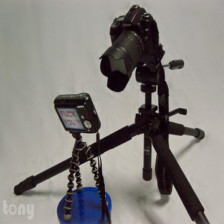

In [175]:
index = 102
input, target = solver.get_item(index)
img = tv.transforms.ToPILImage()(unnorm(input.squeeze(0).cpu().detach()))

print(idx2ctgr[target.cpu().item()])
img

In [176]:
cam = solver.get_heatmaps(input, target.item(), phase='test', mc=1)

In [177]:
eps = 0.007
adv_attack = attack.attack_fgsm(model, input, target, eps)
adv_img = attack.get_adversarial_image(img, adv_attack)
adv_input = attack.image2input(adv_img, norm, device)
adv_cam = solver.get_heatmaps(adv_input, target.item(), phase='test', mc=1)
adv_predict_target, _, _ = attack.inference(model, adv_input, idx2ctgr)

In [178]:
wrong_predict_cam = solver.get_heatmaps(input, adv_predict_target, 
                                        phase='test', mc=1)
wrong_predict_adv_cam = solver.get_heatmaps(adv_input, adv_predict_target, 
                                            phase='test', mc=1)

origin:  (872, 'tripod', 0.8607923984527588)
attack:  (786, 'sewing_machine', 0.8767999410629272)


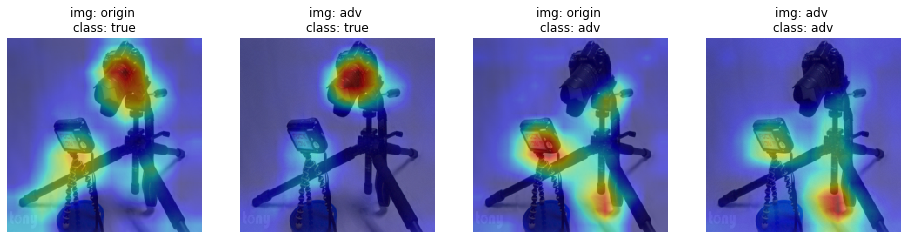

In [179]:
print('origin: ', attack.inference(model, input, idx2ctgr))
print('attack: ', attack.inference(model, adv_input, idx2ctgr))
seq = [(img,cam), (adv_img,adv_cam), (img,wrong_predict_cam), (adv_img,wrong_predict_adv_cam)]
title_seq = [('origin','true'), ('adv','true'), ('origin','adv'), ('adv','adv')]
_, ax = plt.subplots(1,4, figsize=(16,4))
for i, ((image,heatmap), title) in enumerate(zip(seq, title_seq)):
    ax[i].set_title('img: {} \nclass: {}'.format(title[0], title[1]))
    ax[i].imshow(image)
    ax[i].imshow(heatmap, alpha=0.5, cmap='jet')
    ax[i].axis('off')
plt.show()

In [180]:
unnorm_cam = solver.get_heatmaps(input, target.item(), phase='test', mc=1, norm=False)
unnorm_cam_adv = solver.get_heatmaps(adv_input, target.item(), phase='test', mc=1, norm=False)
unnorm_cam_wrpred = solver.get_heatmaps(input, adv_predict_target, phase='test', mc=1, norm=False)
unnorm_cam_adv_wrpred = solver.get_heatmaps(adv_input, adv_predict_target, phase='test', mc=1, norm=False)

In [181]:
unnorm_cam.max(), unnorm_cam_adv.max()

(0.0002548059856053442, 0.00024033928639255464)

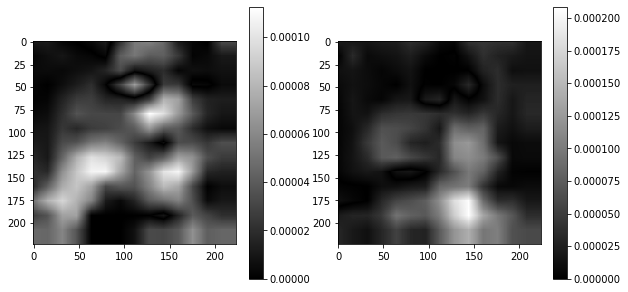

In [182]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(np.abs(unnorm_cam - unnorm_cam_adv), cmap='gray')
fig.colorbar(im,ax=ax[0])
im = ax[1].imshow(np.abs(unnorm_cam_wrpred - unnorm_cam_adv_wrpred), cmap='gray')
fig.colorbar(im,ax=ax[1])
plt.show()

In [183]:
import torch.nn.functional as F
criterion = attack.criterion

In [193]:
# alpha = 0.5
loss, output_true, pred_true, pred_adv = [], [], [], []
for alpha in np.linspace(0,1,101):
    input_alpha = (1.-alpha)* input + alpha * adv_input
    model.eval()
    model.zero_grad()
    output = model(input_alpha)
    pred = F.softmax(output, dim=1)
    loss.append(criterion(output, target).cpu().detach().item())
    output_true.append(output[:,100].cpu().item())
    pred_true.append(pred[:,target].cpu().item())
    pred_adv.append(pred[:, adv_predict_target].cpu().item())

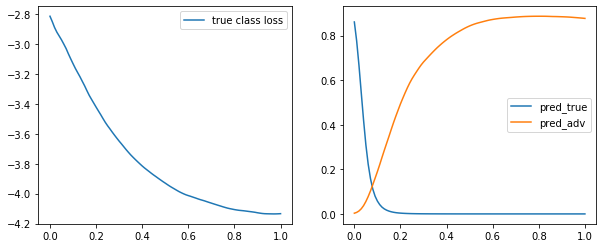

In [194]:
_, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(np.linspace(0,1,101),output_true, label='true class loss')
ax[0].legend(loc='best')
ax[1].plot(np.linspace(0,1,101),pred_true, label='pred_true')
ax[1].plot(np.linspace(0,1,101),pred_adv, label='pred_adv')
ax[1].legend(loc='best')
plt.show()

In [14]:
cam_alphas = []
model.eval()
for alpha in np.linspace(0,1,21):
    input_alpha = (1.-alpha) * input + alpha * adv_input
    model.zero_grad()
    output_alpha = model(input_alpha)
    target_alpha = output_alpha.max(dim=1)[1]
    
    img_alpha = tv.transforms.ToPILImage()(unnorm(input_alpha.squeeze().cpu().detach()))
    cam_alpha = solver.get_heatmaps(input_alpha, target_alpha.item(), phase='test', mc=1)
    cam_alphas.append(cam_alpha)

cam_alphas = torch.tensor(np.stack(cam_alphas)).unsqueeze(1).div(255.)
cam_alphas = tv.transforms.ToPILImage()(tv.utils.make_grid(cam_alphas, nrow=10, padding=10))
cam_alphas = np.array(cam_alphas)[:,:,0]

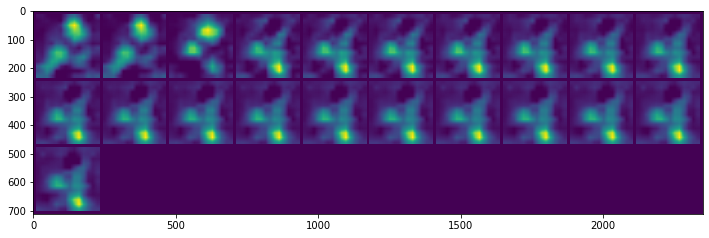

In [15]:
plt.figure(figsize=(12,5))
plt.imshow(cam_alphas)

In [16]:
alpha = 0.5

In [17]:
input_alpha = (1.-alpha) * input + alpha * adv_input
img_alpha = tv.transforms.ToPILImage()(unnorm(input_alpha.squeeze().cpu().detach()))

In [18]:
cam_alpha = solver.get_heatmaps(input_alpha, target.item(), phase='test', mc=1)

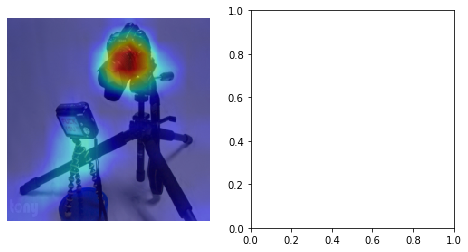

In [19]:
seq = [(img_alpha, cam_alpha)]
_, ax = plt.subplots(1,2, figsize=(4*2,4))
for i, (image,heatmap) in enumerate(seq):
    ax[i].imshow(image)
    ax[i].imshow(heatmap, alpha=0.5, cmap='jet')
    ax[i].axis('off')
plt.show()

### Saliency Map

In [20]:
def get_saliency(input, att_idx):
    input.requires_grad_()
    model.zero_grad()
    output = model(input)
    output[:, att_idx].backward()
    
    saliency = input.grad
    saliency = saliency.squeeze(0).abs().max(dim=0)[0].cpu().numpy()
    return saliency

In [21]:
saliency = get_saliency(input, target)
adv_saliency = get_saliency(adv_input, target)

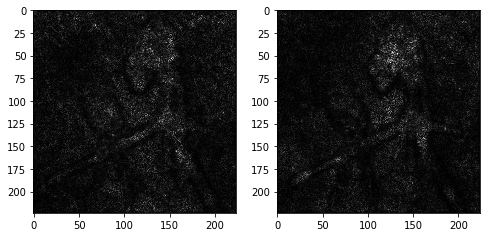

In [22]:
_, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(saliency, cmap='gray')
ax[1].imshow(adv_saliency, cmap='gray')
plt.show()

In [ ]:
# plt.imshow(adv_saliency - saliency, cmap='gray')
# plt.colorbar()
# plt.show()

In [ ]:
def get_integrated_gradient(point_from, point_to, mc=20):
    '''
    return:
        int_grad (Tensor): size = [c,h,w]
    '''
    int_grad = torch.zeros_like(point_to)
    for alpha in np.linspace(0,1,mc+1):
        input_mid = (1.-alpha)*point_from + alpha*point_to
        input_mid.requires_grad = True

        model.zero_grad()
        output_mid = model(input_mid)
        output_mid[:, target].backward(retain_graph=True)

        grad_mid = input_mid.grad
        int_grad += grad_mid
    
    int_grad = (point_to-point_from) * int_grad
    int_grad = int_grad.squeeze(0).mean(dim=0)
    return int_grad

In [ ]:
cam_list = [solver.get_heatmaps(input, i, phase='test', mc=1) for i in range(100)]

In [ ]:
cams = np.stack(cam_list, axis=0)

In [ ]:
cams.shape

In [ ]:
cams_tmp = torch.tensor(cams).unsqueeze(1)
cam_alphas = tv.transforms.ToPILImage()(tv.utils.make_grid(cams_tmp, nrow=10, padding=10))
cam_alphas = np.array(cam_alphas)[:,:,0]

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(cam_alphas)

In [40]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [41]:
import os
from os.path import join, expanduser
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision as tv

import dataloader
import util
from cam import CAM
import attack

In [42]:
idx2ctgr, name2idx = dataloader.get_class_dict(join(expanduser('~'),'data','imagenet'))
norm = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
unnorm = util.UnNormalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])

In [43]:
solver = CAM('vgg')
device = solver.device
model = solver.model
valid_dataset = solver.valid_dataset

In [44]:
# 102: tripod -> sewing machine
# 130: snowmobile -> giant_schnauzer

tripod 872


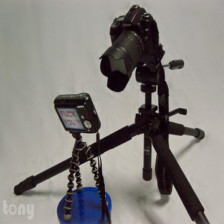

In [199]:
index = 102
input, target = solver.get_item(index)
img = tv.transforms.ToPILImage()(unnorm(input.squeeze(0).cpu().detach()))

print(idx2ctgr[target.cpu().item()], target.item())
img

In [200]:
cam = solver.get_heatmaps(input, target.item(), phase='test', mc=1)

In [201]:
eps = 0.007
adv_attack = attack.attack_fgsm(model, input, target, eps)
adv_img = attack.get_adversarial_image(img, adv_attack)
adv_input = attack.image2input(adv_img, norm, device)
adv_target, _, _ = attack.inference(model, adv_input, idx2ctgr)
adv_target

786

In [202]:
adv_cam = solver.get_heatmaps(adv_input, adv_target, phase='test', mc=1)

In [203]:
eps = 0.007
adv2_attack = attack.attack_fgsm(model, adv_input, torch.tensor([adv_target]).to(device), eps)
adv2_img = attack.get_adversarial_image(adv_img, adv2_attack)
adv2_input = attack.image2input(adv2_img, norm, device)
adv2_target, _, _ = attack.inference(model, adv2_input, idx2ctgr)
adv2_target

691

In [208]:
idx2ctgr[691]

'oxygen_mask'

In [204]:
cam_w_adv = solver.get_heatmaps(adv_input, target.item(), phase='test', mc=1)
adv_cam_w_adv = solver.get_heatmaps(adv2_input, adv_target, phase='test', mc=1)

origin:  (872, 'tripod', 0.8607923984527588)
attack:  (786, 'sewing_machine', 0.8767999410629272)


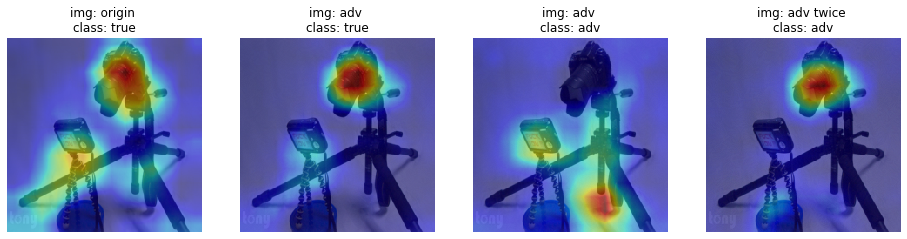

In [205]:
print('origin: ', attack.inference(model, input, idx2ctgr))
print('attack: ', attack.inference(model, adv_input, idx2ctgr))
seq = [(img,cam), (adv_img,cam_w_adv), (adv_img,adv_cam), (adv2_img,adv_cam_w_adv)]
title_seq = [('origin','true'), ('adv','true'), ('adv','adv'), ('adv twice','adv')]
_, ax = plt.subplots(1,4, figsize=(16,4))
for i, ((image,heatmap), title) in enumerate(zip(seq, title_seq)):
    ax[i].set_title('img: {} \nclass: {}'.format(title[0], title[1]))
    ax[i].imshow(image)
    ax[i].imshow(heatmap, alpha=0.5, cmap='jet')
    ax[i].axis('off')
plt.show()

In [206]:
adv2_cam_w_true = solver.get_heatmaps(adv2_input, target.item(), phase='test', mc=1)
adv2_cam_w_adv2 = solver.get_heatmaps(adv2_input, adv2_target, phase='test', mc=1)

(-0.5, 223.5, 223.5, -0.5)

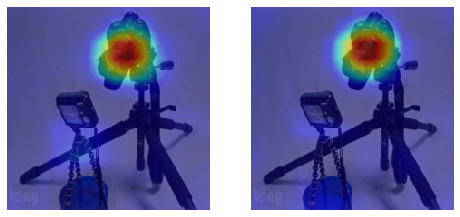

In [207]:
_, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(image)
ax[0].imshow(adv2_cam_w_true, alpha=0.5, cmap='jet')
ax[0].axis('off')
ax[1].imshow(image)
ax[1].imshow(adv2_cam_w_adv2, alpha=0.5, cmap='jet')
ax[1].axis('off')

In [170]:
unnorm_cam = solver.get_heatmaps(input, target.item(), phase='test', mc=1, norm=False)
unnorm_cam_w_adv = solver.get_heatmaps(adv_input, target.item(), phase='test', mc=1, norm=False)
unnorm_adv_cam = solver.get_heatmaps(adv_input, adv_target, phase='test', mc=1, norm=False)
unnorm_adv_cam_w_adv = solver.get_heatmaps(adv2_input, adv_target, phase='test', mc=1, norm=False)

In [171]:
unnorm_cam.max(), unnorm_cam_adv.max()

(0.00039062235737219453, 0.00024033928639255464)

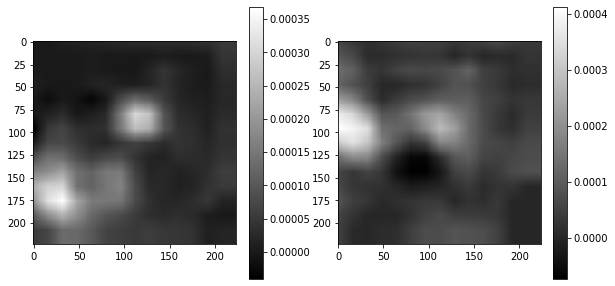

In [172]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(unnorm_cam - unnorm_cam_w_adv, cmap='gray')
fig.colorbar(im,ax=ax[0])
im = ax[1].imshow(unnorm_adv_cam - unnorm_adv_cam_w_adv, cmap='gray')
fig.colorbar(im,ax=ax[1])
plt.show()

In [9]:
wrong_predict_cam = solver.get_heatmaps(input, adv_predict_target, 
                                        phase='test', mc=1)
wrong_predict_adv_cam = solver.get_heatmaps(adv_input, adv_predict_target, 
                                            phase='test', mc=1)

origin:  (872, 'tripod', 0.8607923984527588)
attack:  (786, 'sewing_machine', 0.8767999410629272)


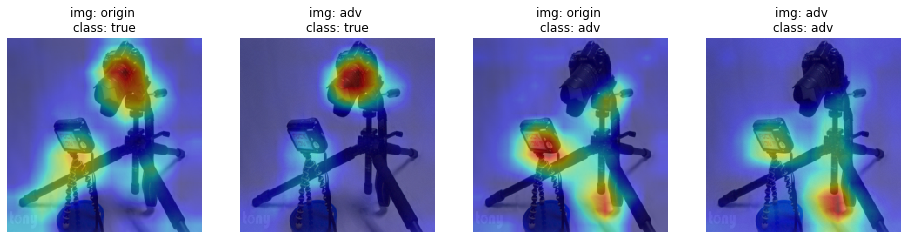

In [10]:
print('origin: ', attack.inference(model, input, idx2ctgr))
print('attack: ', attack.inference(model, adv_input, idx2ctgr))
seq = [(img,cam), (adv_img,adv_cam), (img,wrong_predict_cam), (adv_img,wrong_predict_adv_cam)]
title_seq = [('origin','true'), ('adv','true'), ('origin','adv'), ('adv','adv')]
_, ax = plt.subplots(1,4, figsize=(16,4))
for i, ((image,heatmap), title) in enumerate(zip(seq, title_seq)):
    ax[i].set_title('img: {} \nclass: {}'.format(title[0], title[1]))
    ax[i].imshow(image)
    ax[i].imshow(heatmap, alpha=0.5, cmap='jet')
    ax[i].axis('off')
plt.show()